# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install --upgrade tensorflow opencv-python matplotlib --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 47.0 MB/s eta 0:00:00


In [2]:
!gdown 1SR-03ghw0YIfOp65nZTQTHm72zZyYUGx --q

In [3]:
!gdown 1DCgqXFV8LmULHb7dJNq_isi94xr-AdWs --q

In [4]:
!gdown 14Wx1Kfsj4Zs2PLuI2ojPGmrJNHmWYT6- --q

In [5]:
!gdown 16oxBSlsXPFhmE4Swh4eCEgNe4I26aGkH --q

In [6]:
!unzip -q anchor.zip

In [7]:
!unzip -q positive.zip

In [8]:
!unzip -q negative.zip

In [9]:
!unzip -q verification_images.zip

## 1.2 Import Dependencies

In [10]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [11]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Reshape
import tensorflow as tf

## 1.3 Set GPU Growth

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
len(gpus)

1

In [14]:
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 1.4 Create Folder Structures

In [15]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [16]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [17]:
# http://vis-www.cs.umass.edu/lfw/

In [18]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

tar: lfw.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
# Define the source and destination paths
SRC_PATH = 'anchor'
ANC_PATH = 'data/anchor'

# Ensure the destination directory exists
os.makedirs(ANC_PATH, exist_ok=True)

# Loop through all files in the source path and move them
for file in os.listdir(SRC_PATH):
    ex_path = os.path.join(SRC_PATH, file)
    if os.path.isfile(ex_path):  # Check if it is a file
        new_path = os.path.join(ANC_PATH, file)
        print(f"Moving file from {ex_path} to {new_path}")
        os.replace(ex_path, new_path)

print("All images have been moved to the 'data/anchor' directory.")

In [ ]:
# Define the source and destination paths
SRC_PATH = 'positive'
POS_PATH = 'data/positive'

# Ensure the destination directory exists
os.makedirs(POS_PATH, exist_ok=True)

# Loop through all files in the source path and move them
for file in os.listdir(SRC_PATH):
    ex_path = os.path.join(SRC_PATH, file)
    if os.path.isfile(ex_path):  # Check if it is a file
        new_path = os.path.join(POS_PATH, file)
        print(f"Moving file from {ex_path} to {new_path}")
        os.replace(ex_path, new_path)

print("All images have been moved to the 'data/positive' directory.")

In [ ]:
import os

# Define the source and destination paths
SRC_PATH = 'negative'
NEG_PATH = 'data/negative'

# Ensure the destination directory exists
os.makedirs(NEG_PATH, exist_ok=True)

# Loop through all files in the source path and move them
for file in os.listdir(SRC_PATH):
    ex_path = os.path.join(SRC_PATH, file)
    if os.path.isfile(ex_path):  # Check if it is a file
        new_path = os.path.join(NEG_PATH, file)
        print(f"Moving file from {ex_path} to {new_path}")
        os.replace(ex_path, new_path)

print("All images have been moved to the 'data/negative' directory.")

## 2.2 Collect Positive and Anchor Classes

In [22]:
# Import uuid library to generate unique image names
import uuid

In [23]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/3b7c3c32-57c8-11ef-ab0f-0242ac1c000c.jpg'

In [24]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [25]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [26]:
# plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [27]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [28]:
import os
import uuid

In [29]:
img_path = os.path.join(ANC_PATH, 'ad7a3dc7-4f42-11ef-b4d2-fa294785e937.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [30]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [31]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [32]:
dir_test = anchor.as_numpy_iterator()

In [33]:
print(dir_test.next())

b'data/anchor/d0919c4d-4f41-11ef-a3c7-fa294785e937.jpg'


## 3.2 Preprocessing - Scale and Resize

In [34]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img,channels=3)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [35]:
img = preprocess('data/anchor/aeb9ee6d-4f42-11ef-a022-fa294785e937.jpg')

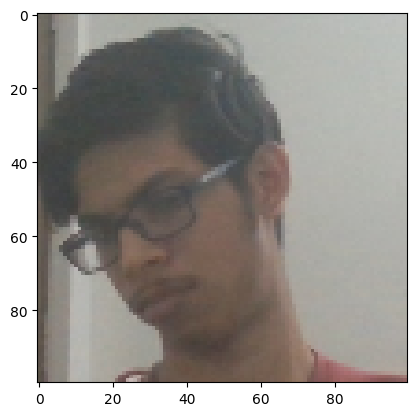

In [36]:
plt.imshow(img)

In [37]:
img.numpy().max()

0.7776961

In [38]:
# dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [39]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [40]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [41]:
samples = data.as_numpy_iterator()

In [42]:
exampple = samples.next()

In [43]:
exampple

(b'data/anchor/cda19b38-4f41-11ef-8e41-fa294785e937.jpg',
 b'data/positive/3c0a4b62-57c8-11ef-ab0f-0242ac1c000c.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [44]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [45]:
res = preprocess_twin(*exampple)

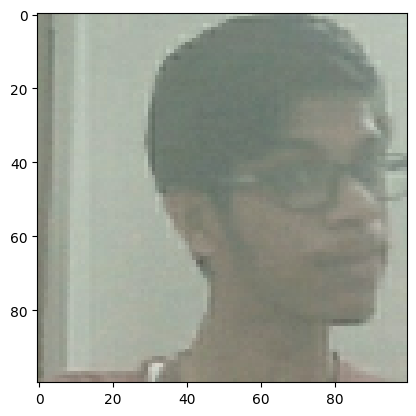

In [46]:
plt.imshow(res[1])

In [47]:
res[2]

1.0

In [48]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [49]:
print(len(data))

600


In [50]:
# Training partition
train_data = data.take(round(len(data)*0.7))
print(len(train_data))
train_data = train_data.batch(16)
print(len(train_data))
train_data = train_data.prefetch(8)
print(len(train_data))

420
27
27


In [51]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [52]:
inp = Input(shape=(100,100,3), name='input_image')

In [53]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [54]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [55]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [56]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [57]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [58]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [59]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [61]:
embedding = make_embedding()

In [62]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [63]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        #Ensure inputs are tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)

        # Compute the Ll distance
        return tf.math.abs(input_embedding - validation_embedding)

    def compute_output_shape(self, input_shape):
        # The output shape is the same as the input shape
        return input_shape[0]

In [64]:
l1 = L1Dist()

In [65]:
# l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [66]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [67]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [68]:
siamese_layer = L1Dist()

In [69]:
distances = siamese_layer(inp_embedding, val_embedding)

In [70]:
classifier = Dense(1, activation='sigmoid')(distances)

In [71]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [72]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [73]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_1 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [75]:
siamese_model = make_siamese_model()

In [76]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_2 (L1Dist)        │ (None, 4096)           │              0 │ embedding[2][0],       │
│                           │                        │                │ embedding[3][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [77]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [78]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [79]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
os.makedirs(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [80]:
print(checkpoint_dir)

./training_checkpoints


## 5.3 Build Train Step Function

In [81]:
test_batch = train_data.as_numpy_iterator()

In [82]:
batch_1 = test_batch.next()

In [83]:
X = batch_1[:2]

In [84]:
y = batch_1[2]

In [85]:
y

array([0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.],
      dtype=float32)

In [86]:
# tf.losses.BinaryCrossentropy??

In [87]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = tf.squeeze(siamese_model(X, training=True))
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 5.4 Build Training Loop

In [88]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [89]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [90]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

only uncomment if you wanna see the positive images

In [91]:
# # Path to the folder containing images
# folder_path = '/content/data/positive'

# # Get list of all image filenames in the folder
# image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# # Number of images per row
# num_images_per_row = 20

# # Calculate number of rows needed
# num_images = len(image_files)
# num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

# # Set up the matplotlib figure
# fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(20, 2 * num_rows))
# plt.subplots_adjust(hspace=0.5)

# # Display each image
# for i, image_file in enumerate(image_files):
#     row = i // num_images_per_row
#     col = i % num_images_per_row
#     img_path = os.path.join(folder_path, image_file)

#     # Open image
#     img = Image.open(img_path)

#     # Resize image to small size if needed
#     img.thumbnail((100, 100))

#     # Convert image to array and display
#     axes[row, col].imshow(np.array(img))
#     axes[row, col].axis('off')  # Hide axes

# # Hide any unused subplots
# for j in range(i + 1, num_rows * num_images_per_row):
#     row = j // num_images_per_row
#     col = j % num_images_per_row
#     axes[row, col].axis('off')

# plt.show()


## 5.5 Train the model

In [92]:
EPOCHS = 50

In [93]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [94]:
if tf.config.list_physical_devices('GPU'):
    print("You are using a GPU.")
else:
    print("You are using a CPU.")

You are using a GPU.


In [95]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━

# 6. Evaluate Model

## 6.1 Import Metrics

In [96]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [97]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [98]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[[1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [4.2276906e-08],
        [6.7368944e-07],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00]]], dtype=float32)

In [99]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat.squeeze() ]

[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]

In [100]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [101]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [102]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [103]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1.0 1.0


In [104]:
len(test_input)

4

In [105]:
len(test_val)

4

In [106]:
y_true

array([0., 1., 0., 1.], dtype=float32)

## 6.4 Viz Results

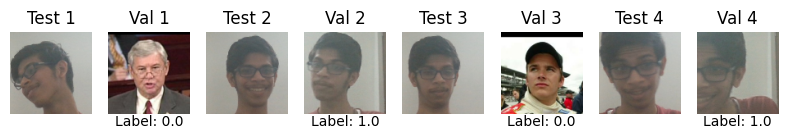

In [107]:
# Number of images to display
num_test_images = len(test_input)
num_val_images = len(test_val)

# Ensure both arrays have the same number of images
num_images = min(num_test_images, num_val_images)

# Number of rows and columns for the grid
num_rows = int(np.ceil(num_images / 4))  # 4 images per row
num_columns = 4  # 4 images per row

# Image size
image_height, image_width = 200, 200

# Plotting combined images
plt.figure(figsize=(num_columns * image_width / 100, num_rows * image_height / 100))

for i in range(num_images):
    row = i // 4
    col = i % 4

    # Test image subplot index
    test_subplot_index = row * num_columns * 2 + col * 2 + 1
    # Validation image subplot index
    val_subplot_index = row * num_columns * 2 + col * 2 + 2

    # Plot test image
    plt.subplot(num_rows, num_columns * 2, test_subplot_index)
    plt.imshow(test_input[i], cmap='gray' if test_input[i].ndim == 2 else None)
    plt.axis('off')
    plt.title(f"Test {i + 1}")

    # plotting the validation image
    plt.subplot(num_rows, num_columns * 2, val_subplot_index)
    plt.imshow(test_val[i], cmap='gray' if test_val[i].ndim == 2 else None)
    plt.axis('off')
    plt.title(f"Val {i + 1}")

    # uh now adding y_true label below validation image
    plt.text(0.5, -0.1, f"Label: {y_true[i]}", ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


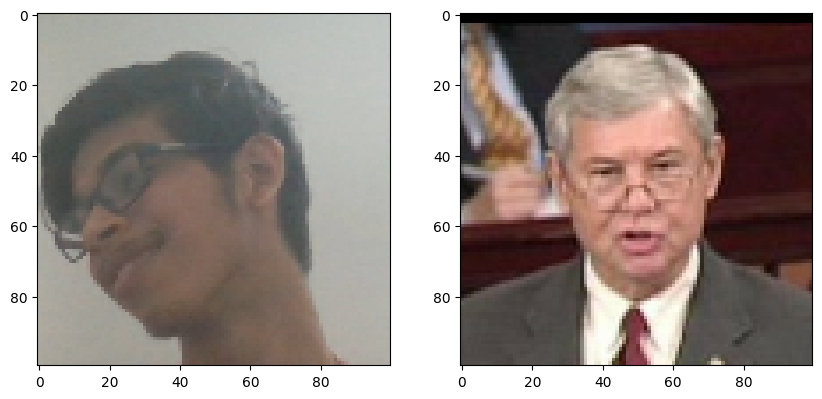

In [108]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [109]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [110]:
L1Dist

__main__.L1Dist

In [112]:
tf.keras.utils.get_custom_objects().update({'L1Dist': L1Dist})

In [113]:
# Reload model
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [114]:
siamese_model.compile(optimizer=opt, loss=tf.losses.BinaryCrossentropy())

In [115]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


array([[[1.6332728e-10],
        [1.0000000e+00],
        [1.0486086e-08],
        [9.9999988e-01]]], dtype=float32)

In [116]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_2 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 116,893,637 (445.91 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,929,092 (297.28 MB)

# 8. Real Time Test

## 8.1 Verification Function

In [117]:
# application_data\verification_images

In [130]:
# Setup paths
verification_images = os.path.join('application_data', 'verification_images')
input_image = os.path.join('application_data', 'input_image')

In [119]:
os.makedirs(verification_images)

In [131]:
os.makedirs(input_image)

In [ ]:
SRC_PATH = 'verification_images'
verification_images = 'application_data/verification_images'

# Ensure the destination directory exists
os.makedirs(verification_images, exist_ok=True)

# Loop through all files in the source path and move them
for file in os.listdir(SRC_PATH):
    ex_path = os.path.join(SRC_PATH, file)
    if os.path.isfile(ex_path):  # Check if it is a file
        new_path = os.path.join(verification_images, file)
        print(f"Moving file from {ex_path} to {new_path}")
        os.replace(ex_path, new_path)

print("All images have been moved to the 'application_data/verification_images' directory.")

In [126]:
os.listdir(os.path.join('application_data', 'verification_images'))

['c56a31a2-4f42-11ef-90da-fa294785e937 - Copy.jpg',
 'c5d8163a-4f42-11ef-8f0f-fa294785e937 - Copy - Copy.jpg',
 'c8a6a63b-4f42-11ef-ad84-fa294785e937 - Copy - Copy.jpg',
 'c70ad81c-4f42-11ef-880a-fa294785e937 - Copy.jpg',
 'c06f6442-4f42-11ef-ba07-fa294785e937 - Copy - Copy.jpg',
 'c6bcf984-4f42-11ef-b5c0-fa294785e937 - Copy - Copy.jpg',
 'be3a2222-4f42-11ef-a2d4-fa294785e937 - Copy - Copy.jpg',
 'c03d6a68-4f42-11ef-956c-fa294785e937 - Copy - Copy.jpg',
 'c903ff6b-4f42-11ef-b3b7-fa294785e937 - Copy.jpg',
 'c664bab8-4f42-11ef-a0b6-fa294785e937 - Copy.jpg',
 'c885897b-4f42-11ef-b130-fa294785e937.jpg',
 'be64f989-4f42-11ef-8fce-fa294785e937 - Copy - Copy.jpg',
 'c741d3d4-4f42-11ef-858e-fa294785e937 - Copy.jpg',
 'c60ca6de-4f42-11ef-bea2-fa294785e937 - Copy.jpg',
 'c3c43e9d-4f42-11ef-a4ec-fa294785e937 - Copy - Copy.jpg',
 'c74b54a0-4f42-11ef-94f5-fa294785e937 - Copy.jpg',
 'c48f0080-4f42-11ef-9d7f-fa294785e937 - Copy.jpg',
 'c3b141ec-4f42-11ef-9662-fa294785e937 - Copy - Copy.jpg',
 'bee155

In [132]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [133]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/c56a31a2-4f42-11ef-90da-fa294785e937 - Copy.jpg
application_data/verification_images/c5d8163a-4f42-11ef-8f0f-fa294785e937 - Copy - Copy.jpg
application_data/verification_images/c8a6a63b-4f42-11ef-ad84-fa294785e937 - Copy - Copy.jpg
application_data/verification_images/c70ad81c-4f42-11ef-880a-fa294785e937 - Copy.jpg
application_data/verification_images/c06f6442-4f42-11ef-ba07-fa294785e937 - Copy - Copy.jpg
application_data/verification_images/c6bcf984-4f42-11ef-b5c0-fa294785e937 - Copy - Copy.jpg
application_data/verification_images/be3a2222-4f42-11ef-a2d4-fa294785e937 - Copy - Copy.jpg
application_data/verification_images/c03d6a68-4f42-11ef-956c-fa294785e937 - Copy - Copy.jpg
application_data/verification_images/c903ff6b-4f42-11ef-b3b7-fa294785e937 - Copy.jpg
application_data/verification_images/c664bab8-4f42-11ef-a0b6-fa294785e937 - Copy.jpg
application_data/verification_images/c885897b-4f42-11ef-b130-fa294785e937.jpg
application_data/verification_

In [134]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

## 8.2 OpenCV Real Time Verification

cant run this as this will only be for vs code

In [ ]:
# cap = cv2.VideoCapture(4)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = frame[120:120+250,200:200+250, :]

#     cv2.imshow('Verification', frame)

#     # Verification trigger
#     if cv2.waitKey(10) & 0xFF == ord('v'):
#         # Save input image to application_data/input_image folder
# #         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# #         h, s, v = cv2.split(hsv)

# #         lim = 255 - 10
# #         v[v > lim] = 255
# #         v[v <= lim] -= 10

# #         final_hsv = cv2.merge((h, s, v))
# #         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
#         # Run verification
#         results, verified = verify(siamese_model, 0.5, 0.5)
#         print(verified)

#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

we will rather do this since colab cant access camera, so we directly upload it here

In [149]:
# Define the path to the uploaded image
image_path = os.path.join('application_data', 'input_image', 'input_image.jpg') #instead of input_image.jpg, for convinience pls use,
                                                                                #just change the name here or rename the file to input_image.jpg

# Check if the image exists
if not os.path.exists(image_path):
    print(f"Image not found at {image_path}. Please check the file path.")
else:
    # Read the uploaded image
    frame = cv2.imread(image_path)

    # Verify the image is loaded correctly
    if frame is None or not frame.size:
        print("The image could not be loaded. Please check the file format and content.")
    else:
        # Perform processing or verification
        output_path = os.path.join('application_data', 'output_image.jpg')
        cv2.imwrite(output_path, frame)

        # Assuming verify function is defined and siamese_model is loaded
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results